In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, mutual_info_score

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
features = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg'
]

df = data[features+['MSRP']].copy()
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [4]:
#@ cleaning data for consistency
df.columns = df.columns.str.lower().str.replace(' ', '_')
for col in list(df.dtypes[df.dtypes == 'object'].index):
    df[col] = df[col].str.lower().str.replace(' ', '_')

#@ filling empty entries with zero
df = df.fillna(0)

#@ converting the MSRP column to `price`
df.columns = df.columns.str.lower().str.replace('msrp', 'price')

## Question 1
What is the most frequent observation (mode) for the column transmission_type?

In [5]:
#@ modal entry for transmission_type
df['transmission_type'].mode()

0    automatic
Name: transmission_type, dtype: object

-----------------------------
## Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

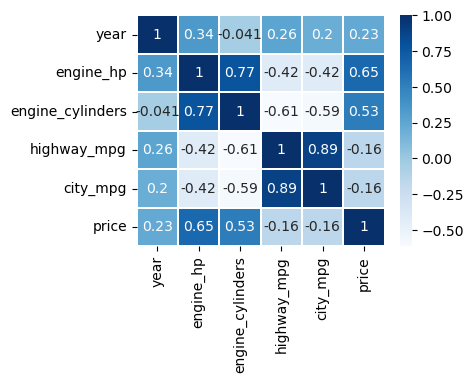

In [6]:
#@ numercial columns
numerical = list(df.dtypes[df.dtypes != 'object'].index)
categorical = list(df.dtypes[df.dtypes == 'object'].index)

#@ correlation matrix
corr_matrix = df[numerical].corr()

#@ visualising the correlation
plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.1)
plt.show()

ans: highway_mpg and city_mpg
<---

In [7]:
#@ making the price binary ie above average, 1. below average, 0.
avg_price = df.price.mean()
df['above_average'] = (df['price'] >= avg_price).astype(int)

In [8]:
#@ splitting the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

del df_train['price']
del df_val['price']
del df_test['price']

### Question 3

    Calculate the mutual information score between above_average and other categorical variables in our dataset. Use the training set only.
    Round the scores to 2 decimals using round(score, 2).

Which of these variables has the lowest mutual information score?

    make
    model
    transmission_type
    vehicle_style


In [9]:
def mutual_info(series):
    return mutual_info_score(df_train['above_average'], series)

score = df_train[categorical].apply(mutual_info)
round(score, 2)

make                 0.24
model                0.46
transmission_type    0.02
vehicle_style        0.08
dtype: float64

Ans: transmission_type

---
### Question 4

    Now let's train a logistic regression.
    Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
    Fit the model on the training dataset.
        To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

    0.60
    0.72
    0.84
    0.95


In [10]:
#@ removing the target variable from the dataframe
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [11]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
dv = DictVectorizer(sparse=False)

In [12]:
#@ converting dataframes to dictionaries and then to vectors
#@ fitting and predicting with our model

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:,1]

In [13]:
churn_decision = (y_pred>=0.5)
y_predictions = churn_decision.astype(int)

global_accuracy_score = accuracy_score(y_val, y_predictions)
round(global_accuracy_score, 2)

0.94

---
## Question 5

    Let's find the least useful feature using the feature elimination technique.
    Train a model with all these features (using the same parameters as in Q4).
    Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
    For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

    year
    engine_hp
    transmission_type
    city_mpg

`Note: the difference doesn't have to be positive`


In [14]:
scores = []
numerical = ['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']

features = categorical+numerical

for feature in features:
    subset = features.copy()
    subset.remove(feature)
    
    train_dicts = df_train[subset].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    model.fit(X_train, y_train)

    val_dicts = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    y_pred = model.predict_proba(X_val)[:,1]
    
    
    churn_decision = (y_pred>=0.5)
    y_predictions = churn_decision.astype(int)

    score = accuracy_score(y_val, y_predictions)
    diff = global_accuracy_score - score
    scores.append((feature, abs(diff)))
scores

[('make', 0.007133864876206486),
 ('model', 0.022660511959714635),
 ('transmission_type', 0.005874947545111198),
 ('vehicle_style', 0.0020981955518254436),
 ('year', 0.009651699538396952),
 ('engine_hp', 0.014687368862777994),
 ('engine_cylinders', 0.008812421317666796),
 ('highway_mpg', 0.003357112882920732),
 ('city_mpg', 0.007553503986571508)]

In [15]:
dd = pd.DataFrame(scores, columns=['feature', 'score'])

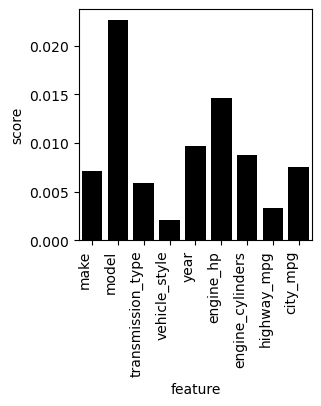

In [18]:
plt.figure(figsize=(3,3))
sns.barplot(x=dd['feature'], y=dd['score'], color='Black', capsize=3)
plt.xticks(rotation=90, ha='right')
plt.show()

Ans: transmission_type

---
### Question 6

    For this question, we'll see how to use a linear regression model from Scikit-Learn.
    We'll need to use the original column price. Apply the logarithmic transformation to this column.
    Fit the Ridge regression model on the training data with a solver 'sag'. Set the seed to 42.
    This model also has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10].
    Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?

    0
    0.01
    0.1
    1
    10

`Note: If there are multiple options, select the smallest alpha.`


In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train['price'].values)
y_val = np.log1p(df_val['price'].values)
y_test = np.log1p(df_test['price'].values)


del df_train['price']
del df_val['price']
del df_test['price']
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [25]:
scores =[]

scaler = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    train_num = scaler.fit_transform(df_train[numerical].values)
    train_cat = ohe.fit_transform(df_train[categorical].values)
    X_train = np.column_stack([train_num, train_cat])
    model.fit(X_train, y_train)

    val_num = scaler.transform(df_val[numerical].values)
    val_cat = ohe.transform(df_val[categorical].values)
    X_val = np.column_stack([val_num, val_cat])

    y_pred = model.predict(X_val)
    
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((a, score))

scores   

[(0, 0.23122851795338742),
 (0.01, 0.22418922721179552),
 (0.1, 0.21475934130808064),
 (1, 0.22963102816535536),
 (10, 0.32273425299218816)]

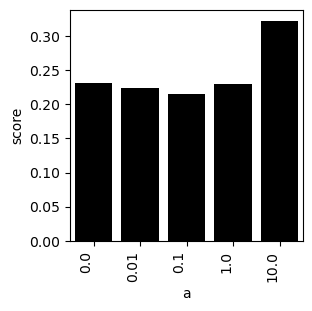

In [26]:
dd = pd.DataFrame(scores, columns=['a', 'score'])
plt.figure(figsize=(3,3))
sns.barplot(x=dd['a'], y=dd['score'], color='Black', capsize=3)
plt.xticks(rotation=90, ha='right')
plt.show()